In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyvallocation.views import FlexibleViewsProcessor
from pyvallocation.portfolioapi import AssetsDistribution, PortfolioWrapper
from pyvallocation.utils.projection import convert_scenarios_compound_to_simple, project_scenarios
from pyvallocation import probabilities
import seaborn as sns

# load daily close data for some ETFs
df = pd.read_csv('../examples/ETF_prices.csv',index_col=0,parse_dates=True)
print('Loaded ', df.columns)

# resample to weekly frequency
weekly_prices = df.resample('W').ffill()

# compute compounded returns
weekly_returns = np.log(weekly_prices).diff().dropna()

# store the returns shape
T, N = weekly_returns.shape

# inputs/parameters
ANNUALIZATION_FACTOR = 52
HALF_LIFE = ANNUALIZATION_FACTOR * 10 # 10 years
TARGET_RETURN = 0.07/ANNUALIZATION_FACTOR

INVESTMENT_HORIZON = 26 # weeks ahead
TARGET_RETURN_HORIZON = TARGET_RETURN*INVESTMENT_HORIZON

Loaded  Index(['DBC', 'GLD', 'SPY', 'TLT'], dtype='object')


## Probability vector

In [2]:
p_exp = probabilities.generate_exp_decay_probabilities(T,HALF_LIFE)
p_uniform = probabilities.generate_uniform_probabilities(T)

## Simple optimization

In [3]:
## mean variance optimization with target return ##
# with exp decay prob.
print('---\nExp decay weights:\n', PortfolioWrapper(AssetsDistribution(scenarios=weekly_returns,probabilities=p_exp)).get_portfolios_return_constraint(TARGET_RETURN))

# with uniform prob
print('---\nUniform prob weights:\n', PortfolioWrapper(AssetsDistribution(scenarios=weekly_returns,probabilities=p_uniform)).get_portfolios_return_constraint(TARGET_RETURN))

Setting default optimizer, call initialize_optimizer to customize it
No custom constraints specified, using default ones
Computing mean and covariance from scenarios
Setting default optimizer, call initialize_optimizer to customize it
No custom constraints specified, using default ones
Computing mean and covariance from scenarios


---
Exp decay weights:
 [DBC    0.052781
GLD    0.267966
SPY    0.326653
TLT    0.352600
dtype: float64]
---
Uniform prob weights:
 [DBC    4.249446e-08
GLD    2.656400e-01
SPY    3.631260e-01
TLT    3.712340e-01
dtype: float64]


In [4]:
# CVaR minimization subject to return costraint, using exponential probabilities
pw = PortfolioWrapper(AssetsDistribution(scenarios=weekly_returns,probabilities=p_exp))
pw.initialize_optimizer(risk_measure='CVaR')
pw.get_portfolios_return_constraint(TARGET_RETURN)

No custom constraints specified, using default ones
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: divide by zero encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: overflow encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: invalid value encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]


[DBC    0.114477
 GLD    0.233732
 SPY    0.212193
 TLT    0.439597
 dtype: float64]

## Projection

In [5]:
# project to horizon
projected_scenarios_exp = project_scenarios(weekly_returns,investment_horizon=INVESTMENT_HORIZON,p=p_exp,n_simulations=1000)

# convert to simple returns
projected_scenarios_exp_simple = convert_scenarios_compound_to_simple(projected_scenarios_exp)

# CVaR minimization subject to return costraint, using exponential probabilities
pw = PortfolioWrapper(AssetsDistribution(scenarios=projected_scenarios_exp_simple))
pw.initialize_optimizer(risk_measure='CVaR')
pw.get_portfolios_return_constraint(TARGET_RETURN_HORIZON)

No custom constraints specified, using default ones
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: divide by zero encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: overflow encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: invalid value encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]


[DBC    0.204223
 GLD    0.162996
 SPY    0.171900
 TLT    0.460880
 dtype: float64]

## Imposing views

Prior Effective number of scenarios: 878.1857281784878
Posterior Effective number of scenarios: 874.650772142869


/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:61: OptimizeWarning: Unknown solver options: maxiter
  solution = minimize(
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: divide by zero encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: overflow encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: invalid value encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:73: RuntimeWarning: divide by zero encountered in matmul
  q_posterior = np.exp(log_p_col - 1.0 - current_lhs.T @ optimal_lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:73: RuntimeWarning: overflo

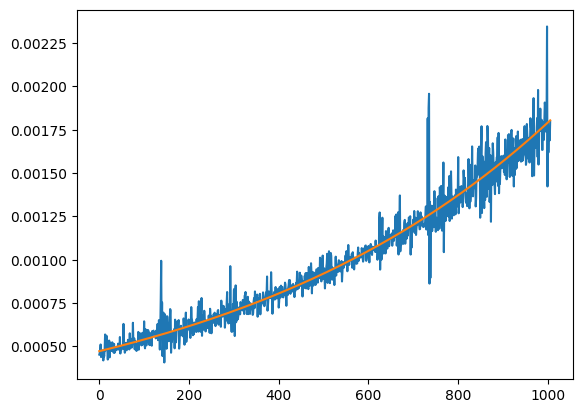

In [6]:
# Suppose we think S&P 500 will deliver 2% and GLD 5% annualized return
mean_views_1 = {"SPY": 0.02/ANNUALIZATION_FACTOR, 'GLD':0.05/ANNUALIZATION_FACTOR}

fv = FlexibleViewsProcessor(
    prior_returns=weekly_returns,
    prior_probabilities=p_exp,
    mean_views=mean_views_1
)

q = fv.get_posterior_probabilities()
print('Prior Effective number of scenarios:',probabilities.compute_effective_number_scenarios(p_exp))
print('Posterior Effective number of scenarios:',probabilities.compute_effective_number_scenarios(q))
plt.plot(q); plt.plot(p_exp); plt.show()

In [7]:
projected_scenarios_compound = project_scenarios(R=weekly_returns,investment_horizon=INVESTMENT_HORIZON,p=q/q.sum())
projected_scenarios_simple = convert_scenarios_compound_to_simple(projected_scenarios_compound)

pw = PortfolioWrapper(AssetsDistribution(scenarios=projected_scenarios_simple))
pw.initialize_optimizer('CVaR')
pw.get_portfolios_return_constraint(TARGET_RETURN_HORIZON)

No custom constraints specified, using default ones
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: divide by zero encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: overflow encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: invalid value encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]


[DBC    0.041641
 GLD    0.240654
 SPY    0.265253
 TLT    0.452451
 dtype: float64]

/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:61: OptimizeWarning: Unknown solver options: maxiter
  solution = minimize(
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: divide by zero encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: overflow encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: invalid value encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)


Prior Effective number of scenarios: 878.1857281784878
Posterior Effective number of scenarios: 788.6240954063023


/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:73: RuntimeWarning: divide by zero encountered in matmul
  q_posterior = np.exp(log_p_col - 1.0 - current_lhs.T @ optimal_lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:73: RuntimeWarning: overflow encountered in matmul
  q_posterior = np.exp(log_p_col - 1.0 - current_lhs.T @ optimal_lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:73: RuntimeWarning: invalid value encountered in matmul
  q_posterior = np.exp(log_p_col - 1.0 - current_lhs.T @ optimal_lagrange_multipliers_col)


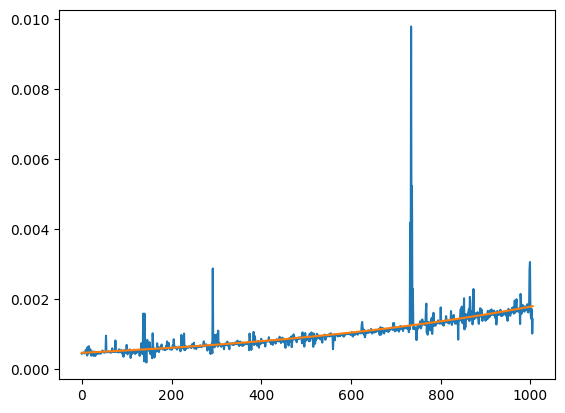

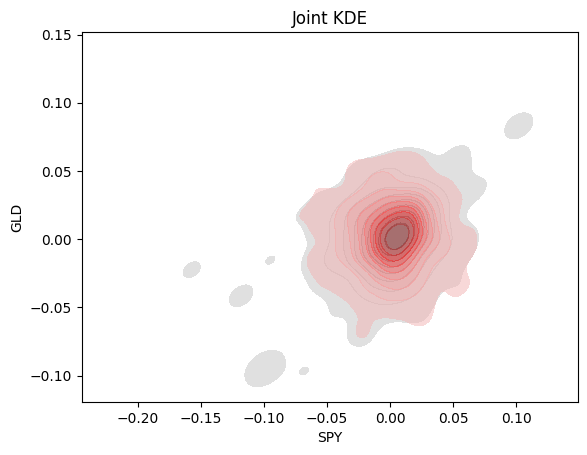

No custom constraints specified, using default ones
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: divide by zero encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: overflow encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/optimization.py:459: RuntimeWarning: invalid value encountered in matmul
  K = (self._losses @ solution[0:self._I] >= solution[-2])[:, 0]


[DBC    0.232369
 GLD    0.119563
 SPY    0.138414
 TLT    0.509653
 dtype: float64]

In [8]:
# Suppose we think SPY will have a >50% correlation with GLD and SPY will have a negative return
mean_views_2 = {'SPY':('<',0)}
corr_views = {('SPY','GLD'):('>',.5)}

q = FlexibleViewsProcessor(
    prior_returns=weekly_returns,
    prior_probabilities=p_exp,
    mean_views=mean_views_2,
    corr_views=corr_views
).get_posterior_probabilities()
print('Prior Effective number of scenarios:',probabilities.compute_effective_number_scenarios(p_exp))
print('Posterior Effective number of scenarios:',probabilities.compute_effective_number_scenarios(q))
plt.plot(q); plt.plot(p_exp); plt.show()

sns.kdeplot(x=weekly_returns['SPY'], y=weekly_returns['GLD'], weights=q, fill=True, alpha=0.5, color='black')

sns.kdeplot(x=weekly_returns['SPY'], y=weekly_returns['GLD'], weights=p_exp,
            fill=True, alpha=0.5, color='red')

plt.xlabel("SPY"); plt.ylabel("GLD"); plt.title("Joint KDE"); plt.show()

projected_scenarios_compound = project_scenarios(R=weekly_returns,investment_horizon=INVESTMENT_HORIZON,p=q)
projected_scenarios_simple = convert_scenarios_compound_to_simple(projected_scenarios_compound)

pw = PortfolioWrapper(AssetsDistribution(scenarios=projected_scenarios_simple))
pw.initialize_optimizer('CVaR')
pw.get_portfolios_return_constraint(TARGET_RETURN_HORIZON)

## Opinion pooling

/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:61: OptimizeWarning: Unknown solver options: maxiter
  solution = minimize(
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: divide by zero encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: overflow encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:18: RuntimeWarning: invalid value encountered in matmul
  x = np.exp(log_p_col - 1.0 - lhs.T @ lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:73: RuntimeWarning: divide by zero encountered in matmul
  q_posterior = np.exp(log_p_col - 1.0 - current_lhs.T @ optimal_lagrange_multipliers_col)
/Users/giuliocantadori/dev/Py-vAllocation/pyvallocation/views.py:73: RuntimeWarning: overflo

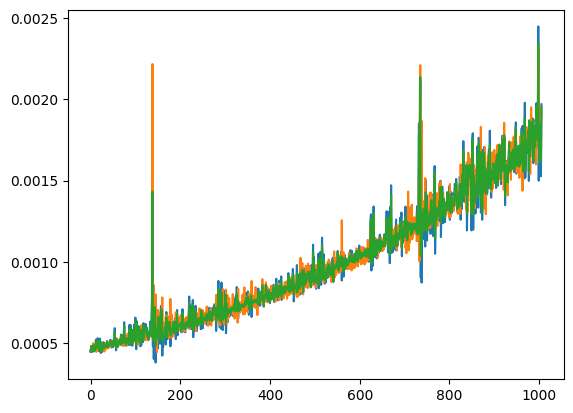

In [9]:
# If we have multiple conflicting views we can leverage the simple opinion pooling

# first view --> SPY returns will be negative
q1 = FlexibleViewsProcessor(
    prior_returns=weekly_returns,
    prior_probabilities=p_exp,
    mean_views={'SPY':('<',0)},
).get_posterior_probabilities()

# second view --> SPY returns will be positive, SPY annualized vol will be >20%
q2 = FlexibleViewsProcessor(
    prior_returns=weekly_returns,
    prior_probabilities=p_exp,
    mean_views={'SPY':('>',0),'TLT':-0.05/ANNUALIZATION_FACTOR},
    vol_views={'SPY':('>',0.2/(ANNUALIZATION_FACTOR**.5))}
).get_posterior_probabilities()

# final probability vector, assigning 75% confidence to the first and 25% to the second view
q_ = q1*.75 + q2*.25

plt.plot(q1);plt.plot(q2);plt.plot(q_)